## Correlation between Arrests  and Venue Type in NYC

1.	Introduction

1.1.	Background

The crime rate in NYC has consistently decreased in the last several decades as shown in the figure below provided by NYPD.
But there are still, as shown above over 100,000 crimes committed every year and the decrease seems to have leveled off in the last few years. Reducing the crime rate stays a priority for the city. 


1.2.	Problem Description
It would be interesting to understand what are the areas with higher crime rate and study whether the type of venues that are established in those areas are in any way correlated to the type or number of arrests performed in those areas. Having that knowledge could help improve the allocation of security resources and focus safety messages to patrons. 
It is understood the study could yield inconclusive results or no result at all. It is still interesting to try to answer the question and demonstrate the tools and technics learned throughout the data science course. 

1.3.	Report Audience and Stakeholders
If valuable insight is found out of the data through the study, the completed report could be presented to venue owners whose business is located in risk areas.  
2.	Data  

2.1.	Arrest Data 
The site https://opendata.cityofnewyork.us/ provides useful public data about NYC. In particular it contains data listing all the arrests in NYC since 2013: NYPD Arrests Data (Historic) – Note: you need to create an account (it’s free) to access the data.
This is a considerable amount of data that goes back several years, it contains millions of records. The venue data that we have access to through Foursquare (described in the next section) is current data, not historic data, so we will limit our study to the arrests recorded in the first 6 months of 2019. The site provides these data as well in a separate data set: NYPD Arrests Data (Year to Date). Reducing the data set could impact the study but it will help us manage the limited computing resource that are available to us for free (IBM Watson)
The Arrests data set contains a log of all the arrests performed in NYC from Jan-1-2019 to June-30-2019. There are a dozen field included for each record. The field of interests for this exercise are:
•	OFNS_DESC which is the type of offense committed

•	Latitude and Longitude: The coordinate of the location where the arrest took place. we will use these 2 fields to query Foursquare to get a list of venues around that location.
  
2.2.	Venue Data 
We will use the Foursquare API (https://developer.foursquare.com/) to explore the venues around the arrest locations. The Venue Category is the field we are interested in to try to corollate to the number of arrests or the type of offense that triggered the arrest near that venue.
We will set a radius of 200 meter around the arrest locations in the call to the API. We limit the number of locations we will explore (less than 1000) to manage the restrictions we are under related the number of calls we can performed to the Foursquare API.


 
3.	Methodology
After loading the arrest data set, we cleansed the data by performing the following:
-	Removed arrest types that were not relevant to the problem;
o	Arrests with generic or cryptic description
o	Arrests related to parking violation  

-	Dropped records in the data set that have undefined values

-	We ended up with close to 100,000 arrests locations after cleansing the data. These locations were clustered geographically into 100 groups. 

-	The Foursquare API was called on the cluster center for each cluster to get a list of venues and their category around the arrests clusters

-	Correlations between arrests types and venue category was established. Correlations greater than 0.7 were retained and a regression plot was created for each of them.

-	A Ridge model was built to try to see if the number of arrests around a location could be predicted depending on the types of venues that exists around that location.



In [21]:
# The code was removed by Watson Studio for sharing.

In [2]:
#import necesary libraries
import numpy as np 
import pandas as pd 
import requests
# import k-means from clustering stage

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns; sns.set(color_codes=True)

### Load NYPD Arrests dataset

In [182]:
# The code was removed by Watson Studio for sharing.

SyntaxError: invalid syntax (<ipython-input-182-8f612d204e09>, line 11)

In [4]:
df_arrests = pd.read_csv(filename)


In [5]:
df_arrests.shape

(113651, 17)

In [6]:
df_arrests.head()


,ARREST_KEY,ARREST_DATE,PD_CD,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,199131647,6/30/2019,109.0,106.0,FELONY ASSAULT,PL 1200501,F,K,78,0,<18,M,BLACK,988709,187224,40.680570,-73.983925
1,199109946,6/30/2019,244.0,107.0,BURGLARY,PL 1402000,F,Q,104,0,25-44,M,BLACK,1011210,191981,40.693587,-73.902781
2,199131650,6/30/2019,792.0,118.0,DANGEROUS WEAPONS,PL 2650303,F,K,73,0,18-24,M,BLACK,1007783,185486,40.675770,-73.915162
3,199126329,6/30/2019,922.0,348.0,VEHICLE AND TRAFFIC LAWS,VTL05110A2,M,Q,104,0,25-44,M,WHITE HISPANIC,1017324,198914,40.712596,-73.880699
4,199127207,6/30/2019,339.0,341.0,PETIT LARCENY,PL 1552500,M,K,90,0,45-64,M,WHITE HISPANIC,999701,195491,40.703249,-73.944275


Cleans Data

In [7]:
df_arrests = df_arrests.set_index('OFNS_DESC').drop(['ESCAPE 3','MOVING INFRACTIONS','F.C.A. P.I.N.O.S.', 'MISCELLANEOUS PENAL LAW','VEHICLE AND TRAFFIC LAWS','OFFENSES AGAINST PUBLIC ADMINISTRATION','OTHER TRAFFIC INFRACTION','UNAUTHORIZED USE OF A VEHICLE 3 (UUV)','CHILD ABANDONMENT/NON SUPPORT','ENDAN WELFARE INCOMP','PARKING OFFENSES','DISRUPTION OF A RELIGIOUS SERVICE','UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS','OTHER STATE LAWS (NON PENAL LA','UNAUTHORIZED USE OF A VEHICLE 3 (UUV)','OFFENSES AGAINST PUBLIC ADMINISTRATION', 'ADMINISTRATIVE CODE','OTHER STATE LAWS (NON PENAL LAW)', 'ADMINISTRATIVE CODES']).reset_index()

In [8]:
df_arrests.shape

(90928, 17)

In [9]:
df_arrests.dropna(inplace=True)

In [10]:
df_arrests.shape

(90453, 17)

In [11]:
df_arrests = df_arrests.drop(columns=['ARREST_DATE','ARREST_KEY',  'PD_CD','KY_CD','LAW_CODE','LAW_CAT_CD','JURISDICTION_CODE','AGE_GROUP','PERP_SEX','PERP_RACE','X_COORD_CD','Y_COORD_CD'])

In [ ]:
df_arrests_grouped = df_arrests.groupby('Location').count().sort_values('OFNS_DESC',ascending=False)
df_arrests_grouped.shape

In [ ]:
df_reduced = df_arrests_grouped[df_arrests_grouped["ARREST_PRECINCT"] >=10].sort_values("ARREST_PRECINCT", ascending=False).reset_index()

In [ ]:
df_reduced.shape

In [ ]:
df_arrests_reduced = pd.concat([df_arrests[df_arrests['Location'] == location] for location in df_reduced['Location'].unique()])
df_arrests_reduced.shape

In [ ]:
len(df_arrests_reduced["OFNS_DESC"].unique())

In [ ]:
lats = df_arrests['Latitude']
lngs = []

for location in df_arrests['Location']:
    location_split = location.split(':')
    lats.append(float(location_split[0]))
    lngs.append(float(location_split[1]))



In [ ]:
len(lats)

In [132]:

locations = pd.DataFrame(columns=['lat','lng'])

locations['lat']=df_arrests['Latitude']
locations['lng']=df_arrests['Longitude']


### Cluster arrest locations geographically

In [183]:
# set number of clusters
kclusters = 100

kmeans_locations = KMeans(n_clusters=kclusters, random_state=0).fit(locations)

In [184]:
locations['cluster labels']= kmeans_locations.labels_
locations.shape
len(locations['lng'].unique())

23071

In [16]:
len(kmeans_locations.labels_)

90453

In [17]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [18]:
# create map of cluster centers for locations 
locations_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
cluster = 0
#for lat, lng, cluster in zip(locations['lat'],locations['lng'],locations['cluster labels']):
for lat, lng in zip(kmeans_locations.cluster_centers_[:,0],kmeans_locations.cluster_centers_[:,1]):
    label = folium.Popup(str(lat) + ':' + str(lng) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(locations_map_clusters)
    cluster = cluster+1
locations_map_clusters

### Get venues around locations

In [24]:
# The code was removed by Watson Studio for sharing.

In [25]:
def getNearbyVenues(radius=1000,LIMIT=200):
    cluster = 0
    venues_list=[]
    for lat, lng in zip(kmeans_locations.cluster_centers_[:,0],kmeans_locations.cluster_centers_[:,1]): 
        print("location # ",cluster, " : ",lat,lng) 
       
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            cluster, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
         
        cluster=cluster+1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['location cluster label', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Function to explore the venues near the locations previously identified

#### call the above function on each neighborhood and create a new dataframe called venues

In [130]:

venues = getNearbyVenues()


In [93]:
# The code was removed by Watson Studio for sharing.

In [29]:
venues.shape


(7913, 7)

In [94]:
venues.head()

,location cluster label,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,40.834444,-73.920238,Bronx Museum of the Arts,40.831307,-73.919949,Art Museum
1,0,40.834444,-73.920238,Bleacher Creatures,40.829309,-73.925509,Athletics & Sports
2,0,40.834444,-73.920238,NYCFC,40.829597,-73.926213,Soccer Field
3,0,40.834444,-73.920238,Yankee Stadium,40.829869,-73.926584,Baseball Stadium
4,0,40.834444,-73.920238,Joyce Kilmer Park,40.828850,-73.922367,Park


In [95]:
#save venues to file so don't have to reload (to avoid going over foursquare quota)
#project.save_data('va_100centroids_radius1000m_arrestsgt10.csv', venues.to_csv())

#### Let's find out how many unique categories can be curated from all the returned venues

In [32]:
print('There are {} unique locations and {} unique categories.'.format(len(venues['location cluster label'].unique()),len(venues['Venue Category'].unique())))


There are 100 unique locations and 396 unique categories.


### Transform data for analysis and modeling

In [135]:
df_arrests_joined = pd.concat([df_arrests,locations],axis=1)


In [45]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
arrests_onehot = pd.get_dummies(df_arrests[['OFNS_DESC']], prefix="", prefix_sep="")

# addd cluster label column back
venues_onehot['cluster labels'] = venues['location cluster label'] 
arrests_onehot['cluster labels'] = df_arrests_joined['cluster labels']

# move location column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

# move location column to the first column
fixed_columns = [arrests_onehot.columns[-1]] + list(arrests_onehot.columns[:-1])
arrests_onehot = arrests_onehot[fixed_columns]

In [46]:
venues_onehot.shape

(7913, 397)

In [47]:
venues_onehot.head()

,cluster labels,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,...,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
arrests_onehot.shape

(90453, 49)

In [49]:
arrests_onehot.head()

,cluster labels,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL MISCHIEF & RELATED OFFENSES,CRIMINAL TRESPASS,...,OTHER OFFENSES RELATED TO THEFT,OTHER STATE LAWS,PETIT LARCENY,POSSESSION OF STOLEN PROPERTY,POSSESSION OF STOLEN PROPERTY 5,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT-FRAUD
0,86,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,97,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,97,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,35,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [98]:
venues_grouped = venues_onehot.groupby('cluster labels').mean().reset_index()
venues_grouped.shape


(100, 142)

In [99]:
arrests_grouped = arrests_onehot.groupby('cluster labels').mean().reset_index()
arrests_grouped.shape


(100, 49)

In [100]:
arrests_venues_grouped = arrests_grouped.join(venues_grouped.set_index('cluster labels'),on='cluster labels')

In [103]:
corr = arrests_venues_grouped.corr(method='pearson')

In [104]:
corr.shape


(190, 190)

In [105]:
corr.head()


,cluster labels,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CRIMINAL MISCHIEF & RELATED OF,CRIMINAL MISCHIEF & RELATED OFFENSES,CRIMINAL TRESPASS,...,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
cluster labels,1.000000,-0.104176,-0.103445,-0.039262,0.044811,0.028177,-0.122100,0.022043,-0.143186,-0.105109,...,0.090271,0.067164,0.126245,0.058010,0.055119,0.112350,-0.007973,0.034258,0.009979,0.002872
ALCOHOLIC BEVERAGE CONTROL LAW,-0.104176,1.000000,-0.042455,-0.083811,-0.065069,-0.106199,-0.114196,-0.053671,-0.059444,0.151422,...,-0.078686,-0.034451,0.034468,0.006491,0.029697,-0.089904,-0.086121,-0.096775,-0.127578,-0.093051
ANTICIPATORY OFFENSES,-0.103445,-0.042455,1.000000,0.157359,-0.113641,0.037717,0.007269,-0.002465,0.059136,0.116763,...,-0.051565,-0.057963,0.150544,-0.115865,-0.057562,0.070271,0.405923,0.106482,0.010625,0.106041
ARSON,-0.039262,-0.083811,0.157359,1.000000,-0.075606,-0.022184,0.093357,-0.034107,0.186025,0.095782,...,-0.010759,0.252964,-0.010386,-0.195676,-0.091657,-0.052374,0.049353,-0.028746,-0.027443,0.091324
ASSAULT 3 & RELATED OFFENSES,0.044811,-0.065069,-0.113641,-0.075606,1.000000,-0.446672,-0.069048,0.016732,0.364191,0.098933,...,-0.268903,0.055678,-0.247903,0.013338,0.163016,-0.208590,-0.276756,-0.230561,-0.142613,-0.378235


### Identify Correlations

In [115]:
# find correlactions  greater than threshold
threshold = 0.6
count = 0
j = 0
loffense = []
lvenues = []
corrs = []

for col in corr.columns[1:-1]:
    i=0
    for n in corr[col]:
        if  col != corr.index[i] and (n >= threshold or n <= -threshold):
            if i > df_arrests_joined.groupby('OFNS_DESC').count().shape[0] + 1 and j < df_arrests_joined.groupby('OFNS_DESC').count().shape[0]:
                print ("correlation between {} and {} is {} - their total counts are respectively: {} and {}".format(col,corr.index[i],round(n,2),df_arrests_joined.groupby('OFNS_DESC').count().loc[col,:].Latitude,venues.groupby('Venue Category').count().loc[corr.index[i],:].Latitude))          
                loffense.append(col)
                lvenues.append(corr.index[i])
                count = count +1
                corrs.append(n)
        i=i+1
    j=j+1    
print("there are {} correlations".format(count))

correlation between ALCOHOLIC BEVERAGE CONTROL LAW and Theme Park is 0.7 - their total counts are respectively: 240 and 12
correlation between ALCOHOLIC BEVERAGE CONTROL LAW and Theme Park Ride / Attraction is 0.7 - their total counts are respectively: 240 and 12
correlation between BURGLAR'S TOOLS and Lingerie Store is 0.65 - their total counts are respectively: 360 and 15
correlation between GAMBLING and Tea Room is 0.67 - their total counts are respectively: 325 and 19
correlation between GRAND LARCENY and Cycle Studio is 0.62 - their total counts are respectively: 5033 and 15
correlation between PETIT LARCENY and Lingerie Store is 0.62 - their total counts are respectively: 11187 and 15
there are 6 correlations


### Display correlations

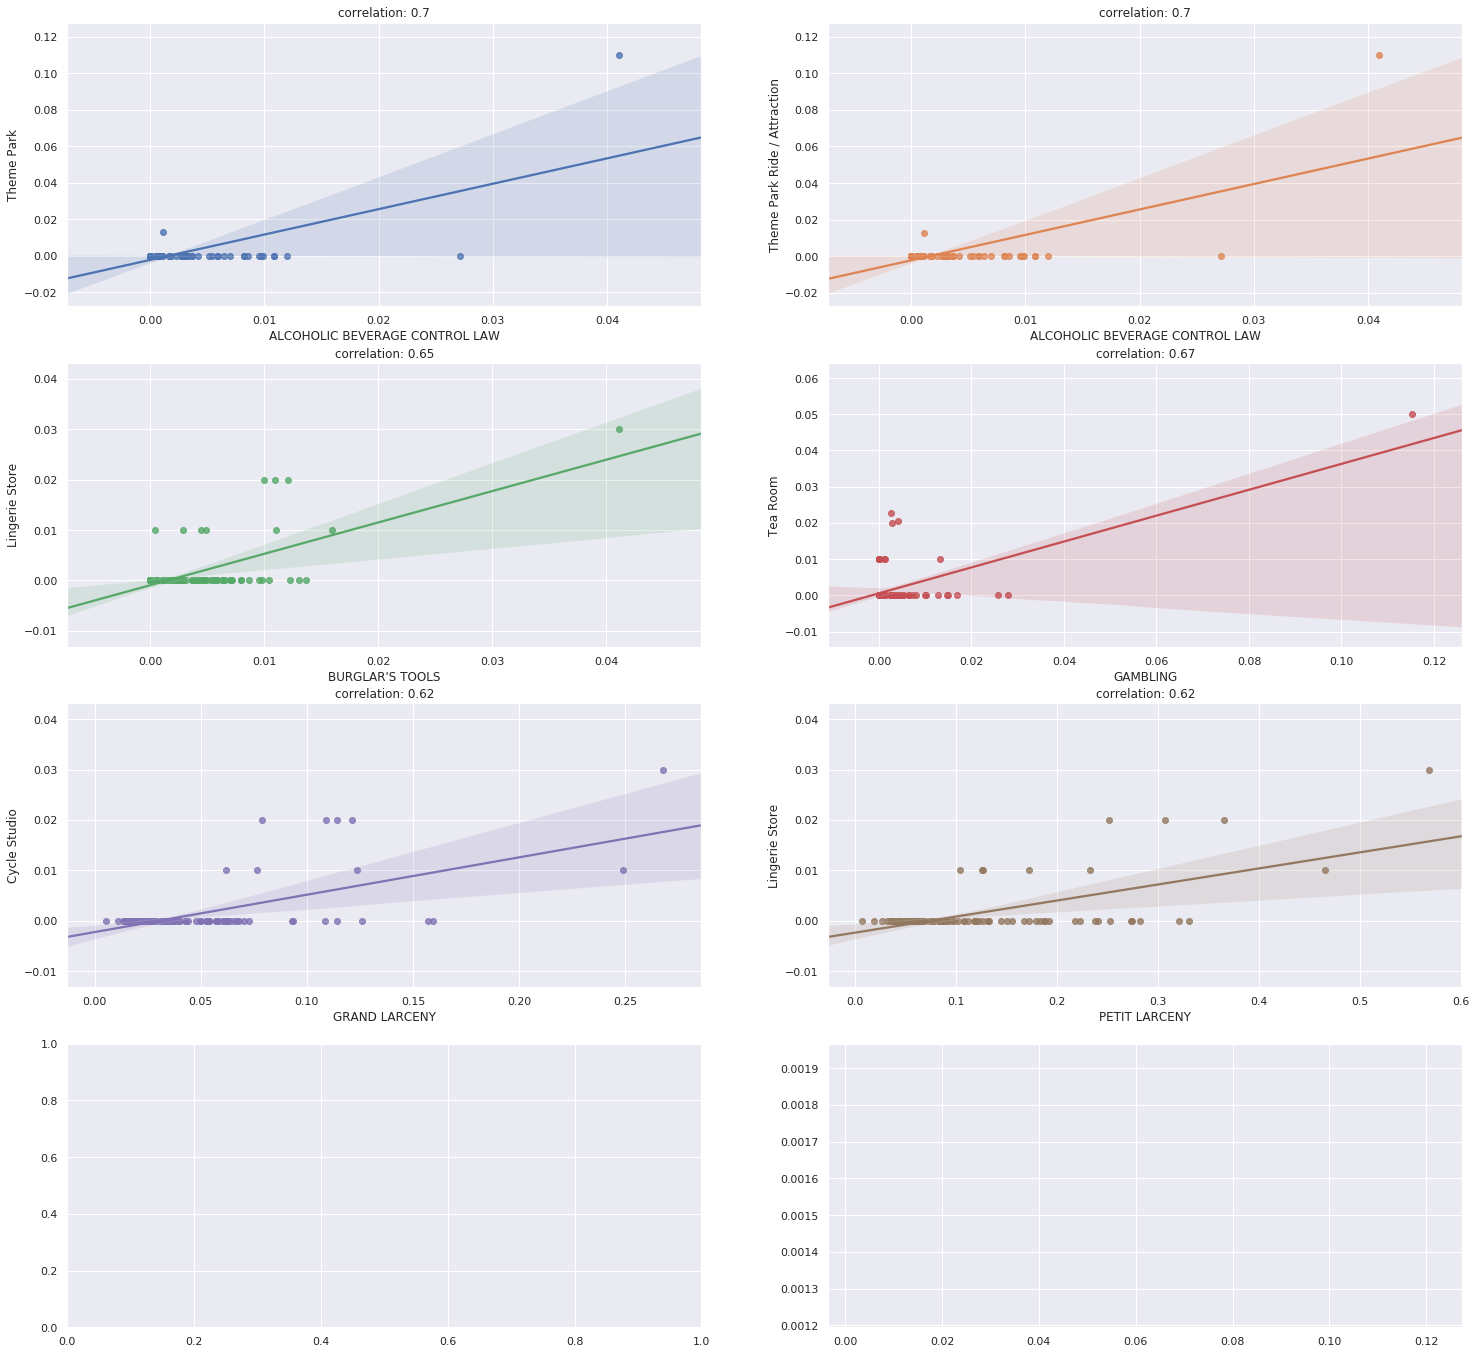

In [118]:
n1,_ = divmod(count,2)
fig, ax =plt.subplots(n1+1,2,figsize=(25,8*n1))
fig.show()
i=0
for offense,category in zip(loffense,lvenues):
    ax1,ax2 = divmod(i,2)
    sns.regplot(x=offense,y=category,data=arrests_venues_grouped, ax=ax[ax1,ax2])
    ax[ax1,ax2].title.set_text('correlation: {}'.format(round(corrs[i],2)))
    i=i+1


### Build linear and polynomial models

In [171]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = venues_grouped
X = X.drop(columns=['cluster labels'])
y = df_arrests_joined.groupby('cluster labels').count().reset_index()['OFNS_DESC']
X.head()
X.shape

(100, 141)

In [172]:
len(y)

100

In [174]:
# split data into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

# split test again so we also have a validate set (50/50)
X_validate, X_test, y_validate, y_test = train_test_split( X_test, y_test, test_size=0.5, random_state=4)

# so we end upo with 3 sets: Taining (80% of the data), Validation (10% of the data), Test *10% of the data)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validate set:', X_validate.shape,  y_validate.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (80, 141) (80,)
Validate set: (10, 141) (10,)
Test set: (10, 141) (10,)


In [175]:
parameters2 = [{'alpha':[0.001,0.1,1,10,100], 'normalize' : [True,False]}]
RR = Ridge()
Grid1 = GridSearchCV(RR,parameters2,cv=4)
Grid1.fit(X_train, y_train)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100], 'normalize': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [176]:
print('best alpha',Grid1.best_estimator_.alpha)
print('normalize?',Grid1.best_estimator_.normalize)

best alpha 10
normalize? True


In [177]:
# Ridge Model
reg = Ridge(alpha=Grid1.best_estimator_.alpha,normalize=Grid1.best_estimator_.normalize)
reg.fit(X_train, y_train) 


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [178]:
reg.score(X_train,y_train)

0.393702455076674

In [179]:
reg.score(X_validate,y_validate)

0.2582428019592309

In [180]:
reg.score(X_test,y_test)

0.013365815819114557

In [181]:
 from sklearn.preprocessing import PolynomialFeatures

In [158]:
poly = PolynomialFeatures(degree=2)

In [159]:
X = poly.fit_transform(X)

In [160]:
X

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.00000000e-04],
       [1.00000000e+00, 1.06382979e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [161]:
len(X)

100

In [162]:
len(X[0])

10153